In [62]:
import warnings
import sys

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, auc, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, precision_score, recall_score

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

import plotly as py
print (py.__version__) # requires version >= 1.9.0\n",
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
import plotly.figure_factory as ff
init_notebook_mode(connected=True)

# XGBoost https://xgboost.readthedocs.io/en/latest/
# conda install -c conda-forge xgboost
import xgboost 
from xgboost import XGBClassifier
from xgboost import plot_importance

# Microsoft LightGbm https://lightgbm.readthedocs.io/en/latest/
# conda install -c conda-forge lightgbm
import lightgbm as lgb 

# Yandex CatBoost https://catboost.yandex/
# conda install -c conda-forge catboost
import catboost 

random_state = 42
np.random.seed(random_state)

from time import strftime, localtime
print("Start: %s" % strftime("%b %d %Y %H:%M:%S", localtime()))

# check catboost #s
# do chart with 3 lines, 3 markers
# do group chart with 3 bars feature importance


3.3.0


Start: Oct 31 2018 00:33:45


In [63]:
data = pd.read_pickle("subsample.pickle")
data.head()


TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0       1           0.0          202500.0    406597.5      24700.5   
1       0           0.0          270000.0   1293502.5      35698.5   
2       0           0.0           67500.0    135000.0       6750.0   
3       0           0.0          135000.0    312682.5      29686.5   
4       0           0.0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0         351000.0                    0.018801     -9461.0         -637.0   
1        1129500.0                    0.003541    -16765.0        -1188.0   
2         135000.0                    0.010032    -19046.0         -225.0   
3         297000.0                    0.008019    -19005.0        -3039.0   
4         513000.0                    0.028663    -19932.0        -3038.0   

   DAYS_REGISTRATION        ...         FLAG_DOCUMENT_12  FLAG_DOCUMENT_13  \
0            -3648.0        ...                        0                 0   
1            -1186.0        ...                        0                 0   
2            -4260.0        ...                        0                 0   
3            -9833.0        ...                        0                 0   
4            -4311.0        ...                        0                 0   

   FLAG_DOCUMENT_14  FLAG_DOCUMENT_15  FLAG_DOCUMENT_16  FLAG_DOCUMENT_17  \
0                 0                 0                 0                 0   
1                 0                 0                 0                 0   
2                 0                 0                 0                 0   
3                 0                 0                 0                 0   
4                 0                 0                 0                 0   

   FLAG_DOCUMENT_18  FLAG_DOCUMENT_19  FLAG_DOCUMENT_20  FLAG_DOCUMENT_21  
0                 0                 0                 0                 0  
1                 0                 0                 0                 0  
2                 0                 0                 0                 0  
3                 0                 0                 0                 0  
4                 0                 0                 0                 0  

[5 rows x 242 columns]

In [64]:
data.groupby(["TARGET"]).count()

CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
TARGET                                                            
0             282686            282686      282686       282686   
1              24825             24825       24825        24825   

        AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
TARGET                                                            
0                282686                      282686      282686   
1                 24825                       24825       24825   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH        ...         \
TARGET                                                           ...          
0              282686             282686           282686        ...          
1               24825              24825            24825        ...          

        FLAG_DOCUMENT_12  FLAG_DOCUMENT_13  FLAG_DOCUMENT_14  \
TARGET                                                         
0                 282686            282686            282686   
1                  24825             24825             24825   

        FLAG_DOCUMENT_15  FLAG_DOCUMENT_16  FLAG_DOCUMENT_17  \
TARGET                                                         
0                 282686            282686            282686   
1                  24825             24825             24825   

        FLAG_DOCUMENT_18  FLAG_DOCUMENT_19  FLAG_DOCUMENT_20  FLAG_DOCUMENT_21  
TARGET                                                                          
0                 282686            282686            282686            282686  
1                  24825             24825             24825             24825  

[2 rows x 241 columns]

In [65]:
# predictors : cols 2 to end
X = data.iloc[:,2:].astype(float)
#X = data.values[:,2:].astype(float)
# response: col 1
y = data["TARGET"].astype(float)


In [66]:
# 69 is first categorical col
first_categorical_column = 69

X.iloc[:10,first_categorical_column:first_categorical_column+3]


REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  CODE_GENDER_F
0                   2.0                          2.0            0.0
1                   1.0                          1.0            1.0
2                   2.0                          2.0            0.0
3                   2.0                          2.0            1.0
4                   2.0                          2.0            0.0
5                   2.0                          2.0            0.0
6                   2.0                          2.0            1.0
7                   3.0                          3.0            0.0
8                   2.0                          2.0            1.0
9                   2.0                          2.0            0.0

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

In [68]:
y_train.head()

181648    0.0
229245    0.0
122525    1.0
306311    1.0
300658    0.0
Name: TARGET, dtype: float64

In [69]:
# given y_true, y_pred, find threshold that gives best f1_score
def best_f1_thresh(y_true, y_pred_proba):
    # get ROC curve thresholds
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
    # compute f1 at each threshold
    f1_scores = [2*p*r/(p+r) for p, r in zip(precision, recall)]
    i  = np.argmax(f1_scores)
    print("Max F1 %.3f, precision %.3f, recall %.3f" % (f1_scores[i], precision[i], recall[i]))
    return thresholds[i], i, recall[i]


In [70]:
# baseline constant model, put everything in the same bucket
y_pred_test_proba = np.ones_like(y_test) * 0.5

# pick threshold for best f1
thresh, threshindex, threshrecall = best_f1_thresh(y_test, y_pred_test_proba)
# make binary prediction
y_pred_test = y_pred_test_proba >= thresh

print("Accuracy: %.04f" % accuracy_score(y_test, y_pred_test))
print("F1 %.04f" % f1_score(y_test, y_pred_test))
print("AUC %.04f" % roc_auc_score(y_score=y_pred_test_proba,y_true=y_test))
print(confusion_matrix(y_test, y_pred_test))

Max F1 0.149, precision 0.081, recall 1.000
Accuracy: 0.0807
F1 0.1494
AUC 0.5000
[[    0 56538]
 [    0  4965]]


In [71]:
# ratio of default to non-default
p_default = sum(y_test)/len(y_test)
p_ratio = (1-p_default)/p_default
print(p_ratio)

11.387311178247733


In [72]:
def profit_at_thresh(y_true, y_pred_proba, l_ratio, thresh):
        y_candidate = y_pred_proba > thresh
        true_negs = sum((y_candidate == 0) &( y_true==0))
        false_negs = sum((y_candidate == 0) &( y_true==1))
        profit = true_negs - false_negs * l_ratio
        return profit

def best_profit_thresh(y_true, y_pred_proba, l_ratio):

    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    plist = []
    print("testing %d thresholds" % len(thresholds))
    for j, thresh in enumerate(thresholds):
        if j % 1000 == 0:
            sys.stdout.write('.')
            sys.stdout.flush()
        y_candidate = y_pred_proba > thresh
        true_negs = sum((y_candidate == 0) &( y_true==0))
        false_negs = sum((y_candidate == 0) &( y_true==1))
        profit = true_negs - false_negs * l_ratio
        #print(j, thresh, true_negs, false_negs, profit)
        plist.append(profit_at_thresh(y_true, y_pred_proba, l_ratio, thresh))
    i = np.argmax(plist)
    thresh = thresholds[i]
    y_candidate = y_pred_proba > thresh
    true_negs = sum((y_candidate == 0) & ( y_true==0))
    false_negs = sum((y_candidate == 0) &( y_true==1))
    print("\nThreshold to maximize value: %f" % thresholds[i])
    print("Performant: %d Nonperformant %d" % (true_negs, false_negs))
    print("FPR %f TPR %f" % (fpr[i], tpr[i]))
    print("Value: %f" % plist[i])
    return thresholds[i], plist[i], tpr[i]

best_profit_thresh(y_test, y_pred_test_proba, 11.387311178247733)
# not sure how it comes up with 1.5 as a threshold when max is 1 
# but it works correctly, max value between approve all/none 
# will be 0 whether you approve all or deny all 

testing 2 thresholds
.
Threshold to maximize value: 1.500000
Performant: 56538 Nonperformant 4965
FPR 0.000000 TPR 0.000000
Value: 0.000000


(1.5, 0.0, 0.0)

In [146]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [147]:
# predict probability, accuracy, value
y_pred_test_proba = model.predict_proba(X_test)[:,1]
# pick threshold for best f1
thresh1, threshindex1, threshrecall1 = best_f1_thresh(y_test, y_pred_test_proba)
# make binary prediction
y_pred_test = y_pred_test_proba >= thresh1

l1_ratio = 11.387311178247733

print("Accuracy: %.03f" % accuracy_score(y_test, y_pred_test))
print("F1 %.03f" % f1_score(y_test, y_pred_test))
print("AUC %.03f" % roc_auc_score(y_score=y_pred_test_proba,y_true=y_test))
print(confusion_matrix(y_test, y_pred_test))
print("profit at max F1: %.02f" % profit_at_thresh(y_test, y_pred_test_proba, l1_ratio, thresh1))


Max F1 0.305, precision 0.254, recall 0.382
Accuracy: 0.860
F1 0.305
AUC 0.753
[[50971  5567]
 [ 3068  1897]]
profit at max F1: 16023.34


In [148]:
print("max profit analysis:")
profit_thresh1, profit1, profitrecall1 =best_profit_thresh(y_test, y_pred_test_proba, l1_ratio)
print("Max profit %.02f, threshold %.08f" % (profit1,profit_thresh1))

max profit analysis:
testing 8633 thresholds
.........
Threshold to maximize value: 0.087486
Performant: 40565 Nonperformant 1690
FPR 0.282536 TPR 0.659617
Value: 21320.444109
Max profit 21320.44, threshold 0.08748636


In [150]:
y_pred_test2 = y_pred_test_proba >= profit_thresh1
print("Accuracy: %.03f" % accuracy_score(y_test, y_pred_test2))
print("F1 %.03f" % f1_score(y_test, y_pred_test2))
print("AUC %.03f" % roc_auc_score(y_score=y_pred_test_proba,y_true=y_test))
print(confusion_matrix(y_test, y_pred_test2))

Accuracy: 0.713
F1 0.271
AUC 0.753
[[40564 15974]
 [ 1690  3275]]


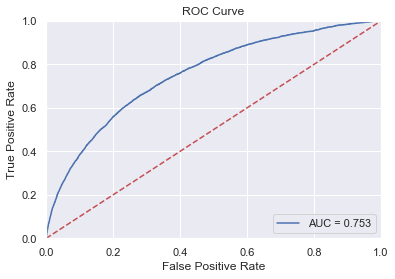

In [75]:
def plot_roc_curve(y_xval, y_pred):
    fpr, tpr, threshold = roc_curve(y_xval, y_pred)
    roc_auc = auc(fpr, tpr)


    plt.title('ROC Curve')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show();
    
plot_roc_curve(y_test, y_pred_test_proba)
#plot profit point, big label

In [78]:
def plotly_roc_curve(y_test, y_pred_test_proba, recall_values=None, recall_labels=None):
    
    fpr, tpr, threshold = roc_curve(y_test, y_pred_test_proba)
    roc_auc = auc(fpr, tpr)
    
    lw = 2
    
    traces = []
    traces.append(Scatter(x=fpr, y=tpr, 
                          mode='lines', 
                          line=dict(color='darkorange', width=lw),
                          name='ROC curve (area = %0.3f)' % roc_auc
                         )
                 )

    traces.append(Scatter(x=[0, 1], y=[0, 1], 
                          mode='lines', 
                          line=dict(color='navy', width=lw, dash='dash'),
                          showlegend=False)
                 )

    if recall_labels:
        # look up closest index in tpr
        for i, recall_label in enumerate(recall_labels):
            recall_value = recall_values[i]
            best_f1_index = np.abs(tpr - recall_value).argmin()
            traces.append(Scatter(x=[fpr[best_f1_index]], 
                                  y=[tpr[best_f1_index]], 
                                  text=recall_label,
                                  mode='markers+text', 
                                  textposition='top left',  
                                  marker = dict(
                                      size = 10,
                                      color = 'rgba(152, 0, 0, .8)',
                                      line = dict(
                                          width = 2,
                                          color = 'rgb(0, 0, 0)'
                                      )
                                  ),
                                  showlegend=False)
                         )
            
    layout = Layout(title='ROC Curve',
                    legend=dict(x=0.75, y=0.05),
                    xaxis=dict(title='False Positive Rate',
                               linecolor='black',
                               linewidth=1,
                               mirror=True,
                               range=[0, 1]                               
                              ),
                    yaxis=dict(title='True Positive Rate',
                               linecolor='black',
                               linewidth=1,
                               mirror=True,
                               range=[0, 1]                               
                              )
                   )
    fig = Figure(data=traces, layout=layout)
    return iplot(fig)

fpr1, tpr1, threshold1 = roc_curve(y_test, y_pred_test_proba)
roc_auc1 = auc(fpr1, tpr1)

plotly_roc_curve(y_test, y_pred_test_proba, recall_values=[threshrecall1, profitrecall1], recall_labels=["Max F1", "Max Profit"])

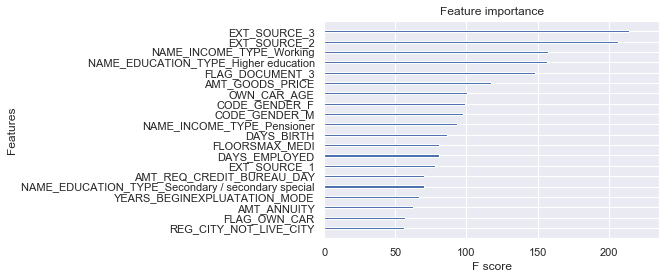

In [79]:
plot_importance(model,importance_type='gain', show_values=False, max_num_features=20);


In [151]:
import operator
featimpdict = model._Booster.get_score(importance_type='gain')

xgb_featlabels=[]
xgb_featimps = []

for key, val in reversed(sorted(featimpdict.items(), key=operator.itemgetter(1))):
    xgb_featlabels.append(key)
    xgb_featimps.append(val)

def plotly_feat_imp(labels, featimps, name):

    trace1 = Bar(
        x=labels[:30],
        y=featimps[:30],
        name=name,
    )

    zlayout = Layout(
        title='%s Feature Importance' % (name),        
        xaxis = dict(title = "", 
                     tickangle=30,
                     tickfont=dict(
                         size=10,
                         color='black'
                     )),
        yaxis = dict(title = "Importance", 
                    ),
        
        margin=layout.Margin(
            b=150,
        ),    
        barmode='group',
    )

    data = [trace1]
    
    fig = Figure(data=data, layout=zlayout)
    iplot(fig)

plotly_feat_imp(xgb_featlabels, xgb_featimps, "Complex Model")


AttributeError: 'Layout' object has no attribute 'Margin'

In [82]:
howmany=30

predictor_names = list(data.columns)[2:]
pd.DataFrame(list(zip(predictor_names,model.feature_importances_[:howmany]))).sort_values(1, ascending=False)

0         1
14                 EXT_SOURCE_3  0.180000
13                 EXT_SOURCE_2  0.162857
12                 EXT_SOURCE_1  0.134286
5                    DAYS_BIRTH  0.057143
3               AMT_GOODS_PRICE  0.037143
1                    AMT_CREDIT  0.032857
6                 DAYS_EMPLOYED  0.032857
2                   AMT_ANNUITY  0.028571
8               DAYS_ID_PUBLISH  0.025714
9                   OWN_CAR_AGE  0.017143
7             DAYS_REGISTRATION  0.012857
0              AMT_INCOME_TOTAL  0.002857
25         LIVINGAPARTMENTS_AVG  0.002857
21                ENTRANCES_AVG  0.002857
17  YEARS_BEGINEXPLUATATION_AVG  0.002857
29              APARTMENTS_MODE  0.002857
11      HOUR_APPR_PROCESS_START  0.001429
20                ELEVATORS_AVG  0.001429
23                FLOORSMIN_AVG  0.001429
24                 LANDAREA_AVG  0.001429
4    REGION_POPULATION_RELATIVE  0.001429
26               LIVINGAREA_AVG  0.001429
16             BASEMENTAREA_AVG  0.000000
18              YEARS_BUILD_AVG  0.000000
19               COMMONAREA_AVG  0.000000
10              CNT_FAM_MEMBERS  0.000000
22                FLOORSMAX_AVG  0.000000
27      NONLIVINGAPARTMENTS_AVG  0.000000
28            NONLIVINGAREA_AVG  0.000000
15               APARTMENTS_AVG  0.000000

In [86]:
# lightgbm 

categorical_features = list(range(72,235))
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
test_data = lgb.Dataset(X_test, label=y_test)

parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model = lgb.train(parameters,
                      train_data,
                      valid_sets=test_data,
                      num_boost_round=5000,
                      early_stopping_rounds=100)

y_pred_test_proba = model.predict(X_test)

thresh2, threshindex2, threshrecall2 = best_f1_thresh(y_test, y_pred_test_proba)
# make binary prediction
y_pred_test = y_pred_test_proba >= thresh2

print("Accuracy: %.03f" % accuracy_score(y_test, y_pred_test))
print("F1 %.03f" % f1_score(y_test, y_pred_test))
print("AUC %.03f" % roc_auc_score(y_score=y_pred_test_proba,y_true=y_test))
print(confusion_matrix(y_test, y_pred_test))
profit_thresh2, profit2, profitrecall2 =best_profit_thresh(y_test, y_pred_test_proba, l1_ratio)


[1]	valid_0's auc: 0.683107
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.722444
[3]	valid_0's auc: 0.727293
[4]	valid_0's auc: 0.728749
[5]	valid_0's auc: 0.734063
[6]	valid_0's auc: 0.734096
[7]	valid_0's auc: 0.735453
[8]	valid_0's auc: 0.735186
[9]	valid_0's auc: 0.735295
[10]	valid_0's auc: 0.737535
[11]	valid_0's auc: 0.737683
[12]	valid_0's auc: 0.738139
[13]	valid_0's auc: 0.738342
[14]	valid_0's auc: 0.738292
[15]	valid_0's auc: 0.739612
[16]	valid_0's auc: 0.73947
[17]	valid_0's auc: 0.73951
[18]	valid_0's auc: 0.740814
[19]	valid_0's auc: 0.741978
[20]	valid_0's auc: 0.742007
[21]	valid_0's auc: 0.742095
[22]	valid_0's auc: 0.743124
[23]	valid_0's auc: 0.743227
[24]	valid_0's auc: 0.743986
[25]	valid_0's auc: 0.744279
[26]	valid_0's auc: 0.744903
[27]	valid_0's auc: 0.745579
[28]	valid_0's auc: 0.745916
[29]	valid_0's auc: 0.745876
[30]	valid_0's auc: 0.746242
[31]	valid_0's auc: 0.746903
[32]	valid_0's auc: 0.747307
[33]	valid_0's auc: 

[277]	valid_0's auc: 0.760705
[278]	valid_0's auc: 0.760751
[279]	valid_0's auc: 0.760721
[280]	valid_0's auc: 0.760733
[281]	valid_0's auc: 0.760781
[282]	valid_0's auc: 0.760763
[283]	valid_0's auc: 0.76078
[284]	valid_0's auc: 0.760806
[285]	valid_0's auc: 0.760789
[286]	valid_0's auc: 0.760719
[287]	valid_0's auc: 0.760734
[288]	valid_0's auc: 0.760729
[289]	valid_0's auc: 0.760713
[290]	valid_0's auc: 0.760717
[291]	valid_0's auc: 0.760657
[292]	valid_0's auc: 0.760686
[293]	valid_0's auc: 0.760648
[294]	valid_0's auc: 0.760667
[295]	valid_0's auc: 0.760717
[296]	valid_0's auc: 0.760705
[297]	valid_0's auc: 0.760764
[298]	valid_0's auc: 0.7607
[299]	valid_0's auc: 0.760769
[300]	valid_0's auc: 0.760767
[301]	valid_0's auc: 0.760762
[302]	valid_0's auc: 0.760815
[303]	valid_0's auc: 0.76081
[304]	valid_0's auc: 0.760803
[305]	valid_0's auc: 0.76085
[306]	valid_0's auc: 0.760854
[307]	valid_0's auc: 0.760865
[308]	valid_0's auc: 0.760829
[309]	valid_0's auc: 0.760836
[310]	valid_0's

In [87]:
fpr2, tpr2, threshold2= roc_curve(y_test, y_pred_test_proba)
roc_auc2 = auc(fpr2, tpr2)

plotly_roc_curve(y_test, y_pred_test_proba, recall_values=[threshrecall2, profitrecall2], recall_labels=["Max F1", "Max Profit"])

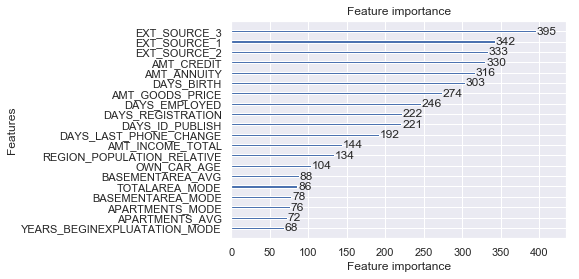

In [88]:
ax = lgb.plot_importance(model, max_num_features=20)
plt.show()

In [89]:
lgb_featimps = model.feature_importance(importance_type='gain')
lgb_featlabels = np.array(model.feature_name())

lgb_indexes = lgb_featimps.argsort()

lgb_featlabels = list(reversed(list(lgb_featlabels[lgb_indexes])))
lgb_featimps = list(reversed(list(lgb_featimps[lgb_indexes])))

plotly_feat_imp(lgb_featlabels, lgb_featimps, "LightGBM")


In [90]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    loss_function='CrossEntropy',
    custom_loss=['AUC', 'Accuracy', 'F1']
    
)
model.fit(
    X_train, y_train,
    cat_features=categorical_features,
    eval_set=(X_test, y_test),
    verbose=False,
    plot=True
    
)
print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Model is fitted: True
Model params:
{'custom_loss': ['AUC', 'Accuracy', 'F1'], 'loss_function': 'CrossEntropy', 'learning_rate': 0.1, 'iterations': 100}


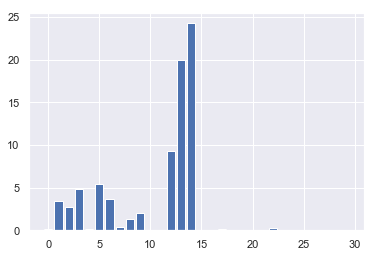

In [126]:
plt.bar(range(howmany), model.feature_importances_[:howmany])
plt.show()

In [127]:
predictor_names = list(data.columns)
pd.DataFrame(list(zip(predictor_names,model.feature_importances_))).sort_values(1, ascending=False)

0          1
14                                        EXT_SOURCE_1  24.289611
13                             HOUR_APPR_PROCESS_START  19.940845
12                                     CNT_FAM_MEMBERS   9.284393
5                                      AMT_GOODS_PRICE   5.404660
3                                           AMT_CREDIT   4.828572
6                           REGION_POPULATION_RELATIVE   3.626879
1                                         CNT_CHILDREN   3.400389
72                         REGION_RATING_CLIENT_W_CITY   3.182418
2                                     AMT_INCOME_TOTAL   2.759520
9                                    DAYS_REGISTRATION   2.055890
93               NAME_EDUCATION_TYPE_Incomplete higher   1.928732
90                            NAME_INCOME_TYPE_Working   1.722038
221                            LIVE_CITY_NOT_WORK_CITY   1.486508
8                                        DAYS_EMPLOYED   1.284774
88                            NAME_INCOME_TYPE_Student   1.239049
205                       ORGANIZATION_TYPE_University   0.865269
64                              DAYS_LAST_PHONE_CHANGE   0.855472
62                            OBS_60_CNT_SOCIAL_CIRCLE   0.814173
206                              ORGANIZATION_TYPE_XNA   0.780293
95   NAME_EDUCATION_TYPE_Secondary / secondary special   0.756912
70                          AMT_REQ_CREDIT_BUREAU_YEAR   0.745469
59                                      TOTALAREA_MODE   0.546644
217                         REG_REGION_NOT_WORK_REGION   0.523471
61                            DEF_30_CNT_SOCIAL_CIRCLE   0.462016
31                                     APARTMENTS_MODE   0.449489
71                                REGION_RATING_CLIENT   0.430122
7                                           DAYS_BIRTH   0.382493
189                         ORGANIZATION_TYPE_Security   0.377516
210                                         FLAG_MOBIL   0.311625
63                            DEF_60_CNT_SOCIAL_CIRCLE   0.304594
..                                                 ...        ...
144                      OCCUPATION_TYPE_Realty agents   0.000000
145                        OCCUPATION_TYPE_Sales staff   0.000000
146                        OCCUPATION_TYPE_Secretaries   0.000000
147                     OCCUPATION_TYPE_Security staff   0.000000
148               OCCUPATION_TYPE_Waiters/barmen staff   0.000000
149                      ORGANIZATION_TYPE_Advertising   0.000000
150                      ORGANIZATION_TYPE_Agriculture   0.000000
151                             ORGANIZATION_TYPE_Bank   0.000000
129                             EMERGENCYSTATE_MODE_No   0.000000
127                    WALLSMATERIAL_MODE_Stone, brick   0.000000
104              NAME_HOUSING_TYPE_Municipal apartment   0.000000
126                           WALLSMATERIAL_MODE_Panel   0.000000
106                 NAME_HOUSING_TYPE_Rented apartment   0.000000
107                     NAME_HOUSING_TYPE_With parents   0.000000
108                  WEEKDAY_APPR_PROCESS_START_FRIDAY   0.000000
109                  WEEKDAY_APPR_PROCESS_START_MONDAY   0.000000
110                WEEKDAY_APPR_PROCESS_START_SATURDAY   0.000000
111                  WEEKDAY_APPR_PROCESS_START_SUNDAY   0.000000
112                WEEKDAY_APPR_PROCESS_START_THURSDAY   0.000000
113                 WEEKDAY_APPR_PROCESS_START_TUESDAY   0.000000
114               WEEKDAY_APPR_PROCESS_START_WEDNESDAY   0.000000
115                   FONDKAPREMONT_MODE_not specified   0.000000
116                FONDKAPREMONT_MODE_org spec account   0.000000
117                FONDKAPREMONT_MODE_reg oper account   0.000000
118           FONDKAPREMONT_MODE_reg oper spec account   0.000000
119                      HOUSETYPE_MODE_block of flats   0.000000
122                           WALLSMATERIAL_MODE_Block   0.000000
123                           WALLSMATERIAL_MODE_Mixed   0.000000
125                          WALLSMATERIAL_MODE_Others   0.000000
239                        

In [128]:
howmany = 30
cat_featlabels = list(data.columns)[1:howmany+1]

cat_featimps_df = pd.DataFrame(list(zip(predictor_names,model.feature_importances_[:howmany]))).sort_values(1, ascending=False)
cat_featlabels = list(cat_featimps_df.iloc[:,0])
cat_featimps = list(cat_featimps_df.iloc[:,1])
plotly_feat_imp(cat_featlabels, cat_featimps, "CatBoost")


In [94]:
y_pred_test_proba = model.predict_proba(data=X_test)[:,1]

thresh3, threshindex3, threshrecall3 = best_f1_thresh(y_test, y_pred_test_proba)
# make binary prediction
y_pred_test = y_pred_test_proba >= thresh

print("Accuracy: %.03f" % accuracy_score(y_test, y_pred_test))
print("F1 %.03f" % f1_score(y_test, y_pred_test))
print("AUC %.03f" % roc_auc_score(y_score=y_pred_test_proba,y_true=y_test))
print(confusion_matrix(y_test, y_pred_test))
profit_thresh3, profit3, profitrecall3 =best_profit_thresh(y_test, y_pred_test_proba, l1_ratio)


Max F1 0.314, precision 0.255, recall 0.407
Accuracy: 0.920
F1 0.023
AUC 0.757
[[56502    36]
 [ 4908    57]]
testing 8450 thresholds
.........
Threshold to maximize value: 0.090944
Performant: 41861 Nonperformant 1782
FPR 0.259613 TPR 0.641088
Value: 21568.811480


In [96]:
fpr3, tpr3, threshold3 = roc_curve(y_test, y_pred_test_proba)
roc_auc3 = auc(fpr3, tpr3)

plotly_roc_curve(y_test, y_pred_test_proba, recall_values=[threshrecall3, profitrecall3], recall_labels=["Max F1", "Max Profit"])

In [29]:
predictor_names = list(data.columns)[1:]


In [30]:
list(enumerate(predictor_names))

[(0, 'CNT_CHILDREN'),
 (1, 'AMT_INCOME_TOTAL'),
 (2, 'AMT_CREDIT'),
 (3, 'AMT_ANNUITY'),
 (4, 'AMT_GOODS_PRICE'),
 (5, 'REGION_POPULATION_RELATIVE'),
 (6, 'DAYS_BIRTH'),
 (7, 'DAYS_EMPLOYED'),
 (8, 'DAYS_REGISTRATION'),
 (9, 'DAYS_ID_PUBLISH'),
 (10, 'OWN_CAR_AGE'),
 (11, 'CNT_FAM_MEMBERS'),
 (12, 'HOUR_APPR_PROCESS_START'),
 (13, 'EXT_SOURCE_1'),
 (14, 'EXT_SOURCE_2'),
 (15, 'EXT_SOURCE_3'),
 (16, 'APARTMENTS_AVG'),
 (17, 'BASEMENTAREA_AVG'),
 (18, 'YEARS_BEGINEXPLUATATION_AVG'),
 (19, 'YEARS_BUILD_AVG'),
 (20, 'COMMONAREA_AVG'),
 (21, 'ELEVATORS_AVG'),
 (22, 'ENTRANCES_AVG'),
 (23, 'FLOORSMAX_AVG'),
 (24, 'FLOORSMIN_AVG'),
 (25, 'LANDAREA_AVG'),
 (26, 'LIVINGAPARTMENTS_AVG'),
 (27, 'LIVINGAREA_AVG'),
 (28, 'NONLIVINGAPARTMENTS_AVG'),
 (29, 'NONLIVINGAREA_AVG'),
 (30, 'APARTMENTS_MODE'),
 (31, 'BASEMENTAREA_MODE'),
 (32, 'YEARS_BEGINEXPLUATATION_MODE'),
 (33, 'YEARS_BUILD_MODE'),
 (34, 'COMMONAREA_MODE'),
 (35, 'ELEVATORS_MODE'),
 (36, 'ENTRANCES_MODE'),
 (37, 'FLOORSMAX_MODE'),
 (38,

In [31]:
from time import strftime, localtime
print("End: %s" % strftime("%b %d %Y %H:%M:%S", localtime()))


End: Oct 30 2018 23:47:29


In [32]:
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)

max_f1_1 = (tpr1)

lw = 2

trace0 = Scatter(x=[0, 1], y=[0, 1], 
                 mode='lines',
                 line=dict(color='navy', width=lw, dash='dash'),
                 showlegend=False)

trace1 = Scatter(x=fpr1, y=tpr1, 
                 mode='lines', 
                 line=dict(color='darkorange', width=lw),
                 name='XGBoost (AUC %.03f)' %roc_auc1
                )

trace2 = Scatter(x=fpr2, y=tpr2, 
                 mode='lines', 
                 line=dict(color='red', width=lw),
                 name='LightGBM (AUC %.03f)' % roc_auc2
                )

trace3 = Scatter(x=fpr3, y=tpr3, 
                 mode='lines', 
                 line=dict(color='green', width=lw),
                 name='CatBoost (AUC %.03f)' % roc_auc3
                )


layout = Layout(title='ROC Curve',
                legend=dict(x=0.75, y=0.05),
                xaxis=dict(title='False Positive Rate',
                           linecolor='black',
                           linewidth=1,
                           mirror=True,
                           range=[0, 1]   
                          ),
                yaxis=dict(title='True Positive Rate',
                           linecolor='black',
                           linewidth=1,
                           mirror=True,
                           range=[0, 1]  
                          )
               )
fig = Figure(data=[trace0, trace1, trace2, trace3], layout=layout)
iplot(fig)


In [142]:
#xgb_featlabels
#lgb_featlabels
#cat_featlabels

# combined top 10
combined_labels = set(xgb_featlabels[:10] + lgb_featlabels[:10] + cat_featlabels[:10])

# dict and index to top
z = [i / xgb_featimps[0]*100 for i in xgb_featimps]
xgb_dict = dict(zip(xgb_featlabels, z))

z = [i / lgb_featimps[0]*100 for i in lgb_featimps]
lgb_dict = dict(zip(lgb_featlabels, z))

z = [i / cat_featimps[0]*100 for i in cat_featimps]
cat_dict = dict(zip(cat_featlabels, z))

xgb_dict['CNT_FAM_MEMBERS']=0
xgb_dict['CNT_CHILDREN']=0
lgb_dict['NAME_EDUCATION_TYPE_Higher education']=0
lgb_dict['CNT_CHILDREN']=0
cat_dict['FLAG_DOCUMENT_3']=0
cat_dict['NAME_EDUCATION_TYPE_Higher education']=0
cat_dict['DAYS_LAST_PHONE_CHANGE']=0
cat_dict['CODE_GENDER_M']=0
cat_dict['CODE_GENDER_F']=0
cat_dict['NAME_INCOME_TYPE_Pensioner']=0
cat_dict['NAME_INCOME_TYPE_Working']=0

[lgb_dict[l] for l in combined_labels]

[2.8386002916311384,
 0,
 1.1801525503579158,
 17.4607481691677,
 17.00066214603117,
 20.55060082723247,
 8.908922749113081,
 9.613273876875967,
 9.083285304297977,
 2.6601964000393896,
 84.54690925176563,
 0.8073585362379726,
 2.6768455612113864,
 5.855774112250429,
 15.73415387153114,
 100.0,
 0,
 2.3394790707332676,
 5.378761263570196,
 5.625617677390691,
 40.082417928150626,
 7.116486830112037,
 17.470110356812167]

In [143]:
# grouped bar
trace1 = Bar(
    x=list(combined_labels),
    y=[xgb_dict[l] for l in combined_labels],
    name='XGBoost'
)
trace2 = Bar(
    x=list(combined_labels),
    y=[lgb_dict[l] for l in combined_labels],
    name='LightGBM'
)
trace3 = Bar(
    x=list(combined_labels),
    y=[cat_dict[l] for l in combined_labels],
    name='CatBoost'
)

data = [trace1, trace2, trace3]
layout = Layout(
    barmode='group'
)

fig = Figure(data=data, layout=layout)
iplot(fig)